In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

from energy_landscape import landscape
from muller_utils import reconstruct_energy

import os, tqdm, pickle, yaml

In [2]:
# result file paths
muller_molsim_path = 'results/muller/base/target_240216_2056'
muller_ogn_path = 'results/muller/ogn/target_240216_2101'
mod_muller_molsim_path = 'results/mod_muller/base/target_240216_2112'
mod_muller_ogn_path = 'results/mod_muller/ogn/target_240216_2116'

In [3]:
def get_projection(traj, start_point, end_point, type, num_points=100):
    # if type(traj) == list:
    #     traj = np.vstack(traj)
    x_all = traj[:, 0] - start_point[0]
    y_all = traj[:, 1] - start_point[1]
    E_all = traj[:, 2]
    z_all = np.sqrt(x_all**2 + y_all**2)
    
    x_values = np.linspace(start_point[0], end_point[0], num_points)
    y_values = np.linspace(start_point[1], end_point[1], num_points)
    z_values = np.sqrt((x_values-start_point[0])**2+(y_values-start_point[1])**2)
    
    # muller_force = MullerForce()
    muller_force = landscape(type)
    E_values = muller_force.potential(x_values, y_values)
    return (z_all, E_all), (z_values, E_values)


def filter_out_outliers(z_all, threshold=3):
    # Calculate the mean and standard deviation
    mean_z = np.mean(z_all)
    std_z = np.std(z_all)

    # Calculate Z-scores
    z_scores = (z_all - mean_z) / std_z

    # Filter out outliers
    z_all = z_all[(z_scores > -threshold) & (z_scores < threshold)]
    return z_all

# Muller potential

In [21]:
pes = landscape('Muller')
x_limits = (-3.4, 1.7)
y_limits = (-1.4, 3.4)
start_point = (-1.5, 2.0)
end_point = (1.0, -0.4)
ft = 15
e = 0.2
label_1 = 'LD'
label_2 = 'GradNav'

In [22]:
with open(os.path.join(muller_molsim_path, 'result.pkl'), 'rb') as file:
    molsim_result = pickle.load(file)

with open(os.path.join(muller_ogn_path, 'result.pkl'), 'rb') as file:
    ogn_result = pickle.load(file)

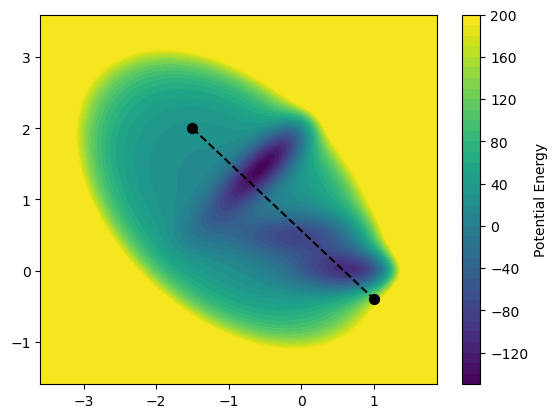

In [23]:
# plot trajectories
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)


plt.scatter(start_point[0], start_point[1], marker='o', s=50, color='k')
plt.scatter(end_point[0], end_point[1], marker='o', s=50, color='k')
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k--')


# save plot
plot_name = 'cutting_plane_combined.png'
plt.savefig(os.path.join(muller_molsim_path, plot_name), 
            bbox_inches='tight', facecolor='w')
plt.savefig(os.path.join(muller_ogn_path, plot_name), 
            bbox_inches='tight', facecolor='w')

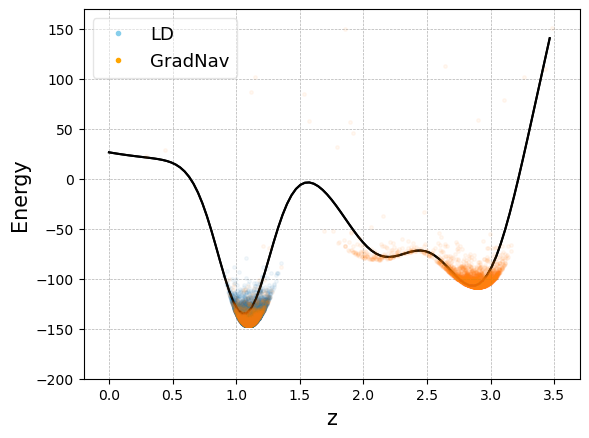

In [24]:
traj_molsim = molsim_result['traj_all_save']
traj_ogn = np.vstack(ogn_result['traj_all_save'])

point_molsim, energy_molsim = get_projection(traj_molsim, start_point, end_point, 'Muller')
point_ogn, energy_ogn = get_projection(traj_ogn, start_point, end_point, 'Muller')

# Plot the energy curve


plt.plot(energy_molsim[0], energy_molsim[1], 'k-')
plt.plot(point_molsim[0], point_molsim[1], '.', 
         markersize=5, alpha=0.05)

plt.plot(energy_ogn[0], energy_ogn[1], 'k-')
plt.plot(point_ogn[0], point_ogn[1], '.', 
         markersize=5, alpha=0.05)

plt.plot([], [], '.', c='skyblue', label=label_1)  # 'o' for circle markers
plt.plot([], [], '.', c='orange', label=label_2)  # 'o' for circle markers

plt.xlim(-0.2, 3.7)
plt.ylim(-200, 170)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=ft-2, loc='upper left', framealpha=0.5)
plt.xlabel('z', fontsize=ft)
plt.ylabel('Energy', fontsize=ft)


# save plot
plot_name = 'energy_curve_combined.png'
plt.savefig(os.path.join(muller_molsim_path, plot_name), 
            bbox_inches='tight', facecolor='w')
plt.savefig(os.path.join(muller_ogn_path, plot_name), 
            bbox_inches='tight', facecolor='w')

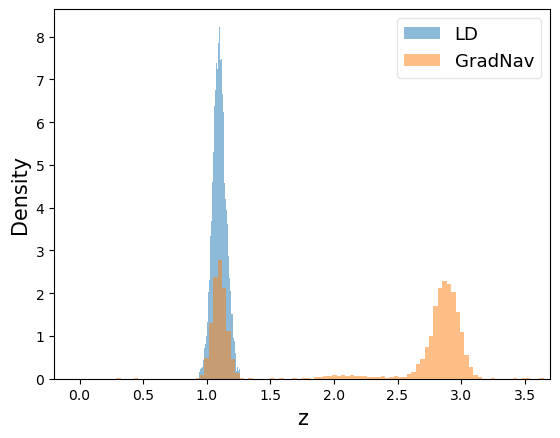

In [25]:
# Plot the distribution
plt.hist(filter_out_outliers(point_molsim[0]), bins=100, 
         density=True, alpha=0.5, label=label_1)
plt.hist(filter_out_outliers(point_ogn[0]), bins=100, 
         density=True, alpha=0.5, label=label_2)
plt.xlabel('z', fontsize=ft)
plt.ylabel('Density', fontsize=ft)
# plt.xlim(-0.2, 3.5)
plt.xlim(-0.2, 3.7)
plt.legend(fontsize=ft-2, loc='upper right', framealpha=0.5)

# save plot
plot_name = 'histogram_combined.png'
plt.savefig(os.path.join(muller_molsim_path, plot_name), 
            bbox_inches='tight', facecolor='w')
plt.savefig(os.path.join(muller_ogn_path, plot_name), 
            bbox_inches='tight', facecolor='w')

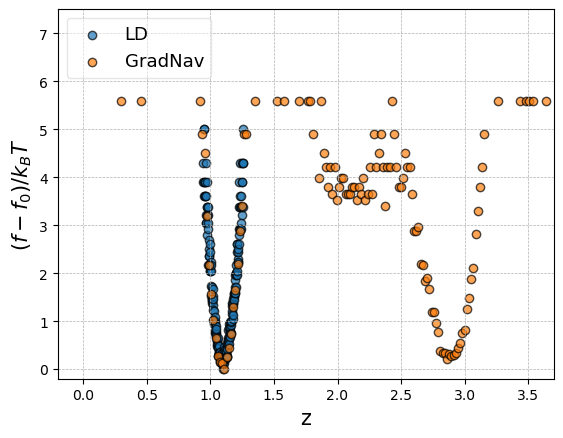

In [26]:
anchors_molsim, fn_molsim = reconstruct_energy(filter_out_outliers(point_molsim[0]), 200)
anchors_ogn, fn_ogn = reconstruct_energy(filter_out_outliers(point_ogn[0]), 200)

# Visualize the results with improved aesthetics
plt.scatter(anchors_molsim, fn_molsim, alpha=0.7, 
            edgecolor='black', label=label_1)
plt.scatter(anchors_ogn, fn_ogn, alpha=0.7, 
            edgecolor='black', label=label_2)

plt.xlabel('z', fontsize=ft)
plt.ylabel(r"$(f - f_0) / k_B T$", fontsize=ft)

# plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.xlim(-0.2, 3.5)
plt.xlim(-0.2, 3.7)
plt.ylim(-0.2, 7.5)
plt.legend(fontsize=ft-2, loc='upper left', framealpha=0.5)

# save plot
plot_name = 'recon_E_combined.png'
plt.savefig(os.path.join(muller_molsim_path, plot_name), 
            bbox_inches='tight', facecolor='w')
plt.savefig(os.path.join(muller_ogn_path, plot_name), 
            bbox_inches='tight', facecolor='w')

# Modified Muller Potential

In [11]:
pes = landscape('Modified_Muller')
x_limits = (-3.5, 2.0)
y_limits = (-1.2, 3.5)
start_point = (-3.1, 3.1)
end_point = (1.5, -0.8)
ft = 15
e = 0.2
label_1 = 'LD'
label_2 = 'GradNav'

In [12]:
with open(os.path.join(mod_muller_molsim_path, 'result.pkl'), 'rb') as file:
    molsim_result = pickle.load(file)

with open(os.path.join(mod_muller_ogn_path, 'result.pkl'), 'rb') as file:
    ogn_result = pickle.load(file)

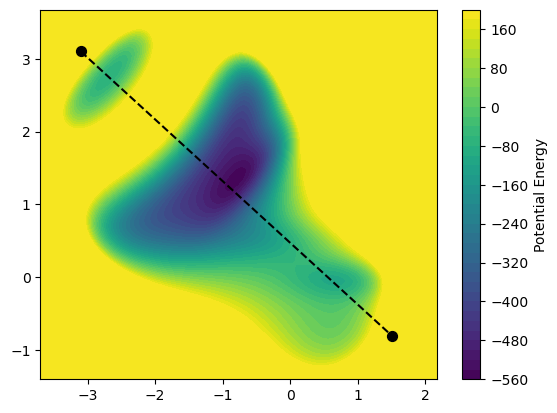

In [13]:
# plot trajectories
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

plt.scatter(start_point[0], start_point[1], marker='o', s=50, color='k')
plt.scatter(end_point[0], end_point[1], marker='o', s=50, color='k')
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k--')

# save plot
plot_name = 'cutting_plane_combined.png'
plt.savefig(os.path.join(mod_muller_molsim_path, plot_name), 
            bbox_inches='tight', facecolor='w')
plt.savefig(os.path.join(mod_muller_ogn_path, plot_name), 
            bbox_inches='tight', facecolor='w')

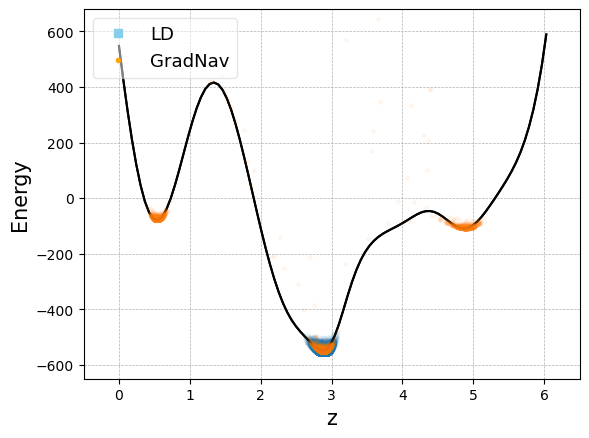

In [14]:
traj_molsim = molsim_result['traj_all_save']
traj_ogn = np.vstack(ogn_result['traj_all_save'])

point_molsim, energy_molsim = get_projection(traj_molsim, start_point, end_point, 'Modified_Muller')
point_ogn, energy_ogn = get_projection(traj_ogn, start_point, end_point, 'Modified_Muller')

# Plot the energy curve


plt.plot(energy_molsim[0], energy_molsim[1], 'k-')
plt.plot(point_molsim[0], point_molsim[1], 's', 
         markersize=5, alpha=0.05)

plt.plot(energy_ogn[0], energy_ogn[1], 'k-')
plt.plot(point_ogn[0], point_ogn[1], '.', 
         markersize=5, alpha=0.05)

plt.plot([], [], 's', c='skyblue', label=label_1)  # 'o' for circle markers
plt.plot([], [], '.', c='orange', label=label_2)  # 'o' for circle markers

plt.xlim(-0.5, 6.5)
plt.ylim(-650, 680)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=ft-2, loc='upper left', framealpha=0.5)
plt.xlabel('z', fontsize=ft)
plt.ylabel('Energy', fontsize=ft)


# save plot
plot_name = 'energy_curve_combined.png'
plt.savefig(os.path.join(mod_muller_molsim_path, plot_name), 
            bbox_inches='tight', facecolor='w')
plt.savefig(os.path.join(mod_muller_ogn_path, plot_name), 
            bbox_inches='tight', facecolor='w')

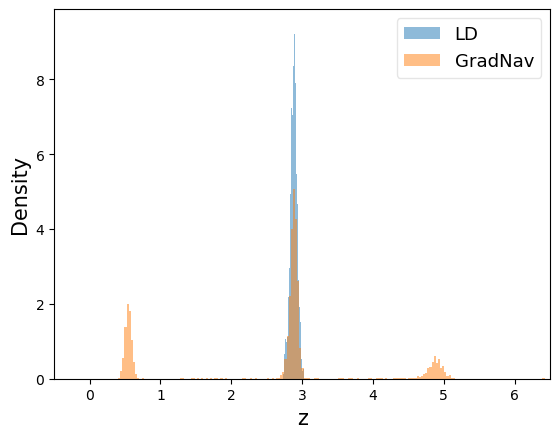

In [19]:
plt.hist(filter_out_outliers(point_molsim[0]), bins=200, 
         density=True, alpha=0.5, label=label_1)
plt.hist(filter_out_outliers(point_ogn[0]), bins=200, 
         density=True, alpha=0.5, label=label_2)
plt.xlabel('z', fontsize=ft)
plt.ylabel('Density', fontsize=ft)
#plt.xlim(-0.2, 3.5)
plt.xlim(-0.5, 6.5)
plt.legend(fontsize=ft-2, loc='upper right', framealpha=0.5)

# save plot
plot_name = 'histogram_combined.png'
plt.savefig(os.path.join(mod_muller_molsim_path, plot_name), 
            bbox_inches='tight', facecolor='w')
plt.savefig(os.path.join(mod_muller_ogn_path, plot_name), 
            bbox_inches='tight', facecolor='w')

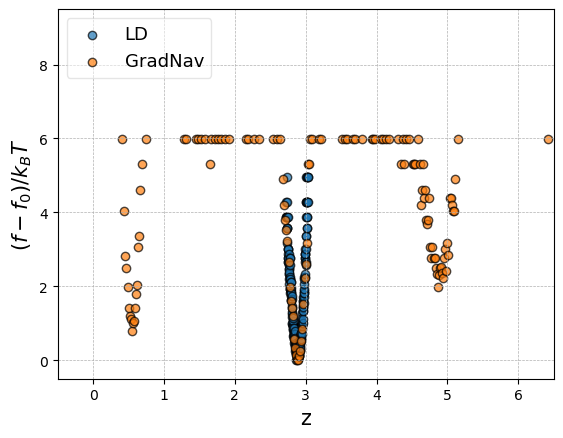

In [20]:
anchors_molsim, fn_molsim = reconstruct_energy(filter_out_outliers(point_molsim[0]), 200)
anchors_ogn, fn_ogn = reconstruct_energy(filter_out_outliers(point_ogn[0]), 400)

# Visualize the results with improved aesthetics
plt.scatter(anchors_molsim, fn_molsim, alpha=0.7, 
            edgecolor='black', label=label_1)
plt.scatter(anchors_ogn, fn_ogn, alpha=0.7, 
            edgecolor='black', label=label_2)

plt.xlabel('z', fontsize=ft)
plt.ylabel(r"$(f - f_0) / k_B T$", fontsize=ft)

# plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.xlim(-0.2, 3.5)
plt.xlim(-0.5, 6.5)
plt.ylim(-0.5, 9.5)
plt.legend(fontsize=ft-2, loc='upper left', framealpha=0.5)

# save plot
plot_name = 'recon_E_combined.png'
plt.savefig(os.path.join(mod_muller_molsim_path, plot_name), 
            bbox_inches='tight', facecolor='w')
plt.savefig(os.path.join(mod_muller_ogn_path, plot_name), 
            bbox_inches='tight', facecolor='w')